In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from typing import Dict
from matplotlib import cm

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
from load_data import load_data
mibig_metadata, mibig_pfam, mibig_cathdb, funfams, sbp, sbp_all_pfam, bios = load_data()

(851, 20)
(918, 166)
(1519, 17)
(96, 10)
(863, 29)
(1345, 100)


In [4]:
### What percentage were too big?
m = pd.read_csv('/groups/banfield/users/alexcc/song_collaboration/bgc_tran/data/metadata/mibig2_metadata.tsv', sep="\t")
print(m.query("Gram == 1 or Gram == 0").query("Orf_length > 60").shape[0])
m.query("Gram == 1 or Gram == 0").query("Orf_length > 60").shape[0] / m.query("Gram == 1 or Gram == 0").shape[0]

28


0.01809954751131222

In [5]:
## What number have structures?
print(mibig_metadata.query("~Structure.isnull()").shape)

(1042, 17)


In [6]:
## What number of fun fams are specific for 1 TCDB?
funfams.query("~TCDB.isnull()").shape[0]

80

In [7]:
## Percentage of BGCs with SBP
mibig_pfam[mibig_pfam.BGC.isin(sbp.BGC)].shape[0] / mibig_pfam.shape[0] * 100

9.870740305522913

1519


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa119528be0>]],
      dtype=object)

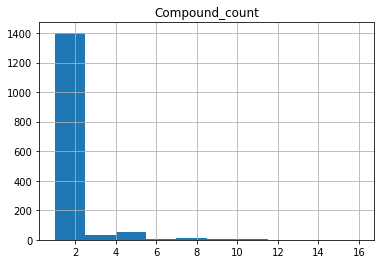

In [8]:
## What number have > 1 structure?
print(## What number have > 1 structure?
mibig_metadata.query("Compound_count >= 1").shape[0])
mibig_metadata.query("Compound_count >= 1").hist("Compound_count")

In [9]:
## General breakdowns

print(str(round(mibig_pfam.shape[0] / float(mibig_metadata.shape[0]) * 100,1)) + "% of MiBIG BGCs have a PFAM transporter")
print(str(round(mibig_cathdb.shape[0] / float(mibig_metadata.shape[0]) * 100,1)) + "% of MiBIG BGCs have a CATHDB transporter")

56.0% of MiBIG BGCs have a PFAM transporter
60.4% of MiBIG BGCs have a CATHDB transporter


In [10]:
## Transporter % by classification

print(mibig_metadata.query("Antibacterial == 1 and Siderophore == 0").BGC.isin(mibig_pfam.BGC).sum() / \
mibig_metadata.query("Antibacterial == 1 and Siderophore == 0").shape[0])

print(mibig_metadata.query("Antifungal == 1 and Siderophore == 0").BGC.isin(mibig_pfam.BGC).sum() / \
mibig_metadata.query("Antifungal == 1 and Siderophore == 0").shape[0])


print(mibig_metadata.query("Siderophore == 1").BGC.isin(mibig_pfam.BGC).sum() / \
mibig_metadata.query("Siderophore == 1").shape[0])

print(mibig_metadata.query("~Activities.isnull() and Antibacterial == 0 and Siderophore == 0").BGC.isin(mibig_pfam.BGC).sum() / \
mibig_metadata.query("~Activities.isnull() and Antibacterial == 0 and Antifungal == 0 and Siderophore == 0").shape[0])


0.705
0.4782608695652174
0.78
0.7070707070707071


55
1


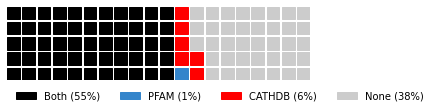

In [23]:
## Percentage plot
import matplotlib.pyplot as plt
from pywaffle import Waffle

have_both = mibig_metadata[mibig_metadata.BGC.isin(mibig_pfam.BGC) & mibig_metadata.BGC.isin(mibig_cathdb.BGC)]
just_pfam = mibig_metadata[mibig_metadata.BGC.isin(mibig_pfam.BGC) & ~mibig_metadata.BGC.isin(mibig_cathdb.BGC)]
just_cath = mibig_metadata[~mibig_metadata.BGC.isin(mibig_pfam.BGC) & mibig_metadata.BGC.isin(mibig_cathdb.BGC)]
neither = mibig_metadata[~mibig_metadata.BGC.isin(mibig_pfam.BGC) & ~mibig_metadata.BGC.isin(mibig_cathdb.BGC)]

both_num = int(round(have_both.shape[0] / float(mibig_metadata.shape[0]) * 100, 0))
pfam_num = int(round(just_pfam.shape[0] / float(mibig_metadata.shape[0]) * 100, 0))
cath_num = int(round(just_cath.shape[0] / float(mibig_metadata.shape[0]) * 100, 0))
neither_num = int(round(neither.shape[0] / float(mibig_metadata.shape[0]) * 100, 0))
print(both_num)
print(pfam_num)
data = {'Both': both_num, 'PFAM': pfam_num, 'CATHDB': cath_num, 'None': neither_num}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=data, 
    colors=("black", "#3485cb", '#FF0000', "#CCCCCC"),
    labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)
plt.savefig("Fig1c.svg")
plt.show()

In [18]:
'#FF0000'

'#FF0000'

In [36]:
mibig_pfam.sum(axis=1).mean()

2.5487661574618095

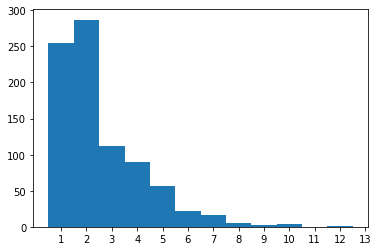

In [24]:
transporter_counts = mibig_pfam[mibig_pfam.columns[1:-1]].sum(axis=1)

bins = np.arange(1, transporter_counts.max() + 1.5) - 0.5
fig, ax = plt.subplots()
ax.set_xticks(bins + 0.5)

transporter_counts.hist(bins=bins)
# plt.axis([1,18])
plt.grid(False)
plt.savefig("Fig1d.svg")
plt.show()

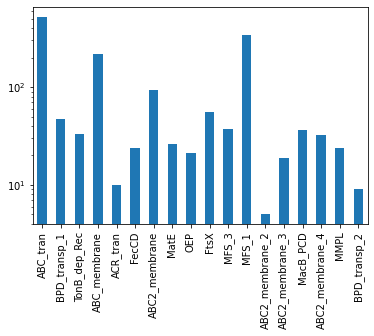

In [25]:
## General plot
total_abund = mibig_pfam.astype(bool).sum()[1:-1]
total_abund.plot.bar()
# plt.ylim(0,1)
plt.yscale('log')
plt.savefig("Fig1b.svg")

plt.show()


In [18]:
### Some key statistics


In [81]:
mibig_pfam.sum()

BGC                BGC0000001BGC0000002BGC0000019BGC0000020BGC000...
ABC_tran                                                         753
BPD_transp_1                                                      81
TonB_dep_Rec                                                      36
ABC_membrane                                                     274
ACR_tran                                                          10
FecCD                                                             44
ABC2_membrane                                                     98
MatE                                                              58
OEP                                                               44
FtsX                                                              78
MFS_3                                                             37
MFS_1                                                            444
ABC2_membrane_2                                                    7
ABC2_membrane_3                   